# Homework, Week 16, Heather Leighton-Dick

In [1]:
## everything and the kitchen sink

import pandas as pd
import numpy as np
import pydotplus
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import where
from numpy import mean
from IPython.display import Image

from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm, datasets


## 1.	Perform combined over and undersampling on the diabetes dataset (use SMOTEENN). 

In [3]:
# import dataset
diabetes_df = pd.read_csv("../Homework14/diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# combined SMOTE and Edited Nearest Neighbors resampling for imbalanced classification

# define model
model = DecisionTreeClassifier()
# define resampling
resample = SMOTEENN()

In [5]:
X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df['Outcome']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y)

# Standardize
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# SMOTEENN combined resampling
resampled = SMOTEENN(random_state = 42)
X_resampled, y_resampled = resampled.fit_resample(X_train, y_train)

# define pipeline
pipeline = Pipeline(steps = [('r', resample), ('m', model)])

# define model
model = tree.DecisionTreeClassifier(max_depth = 8, random_state=42, min_samples_split=50, criterion = 'gini')

In [6]:
model = model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       125
           1       0.57      0.73      0.64        67

    accuracy                           0.71       192
   macro avg       0.70      0.72      0.70       192
weighted avg       0.74      0.71      0.72       192



In [7]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=11, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.740


### Explain how combined sampling works.

SMOTE oversamples by creating new data points along the distances between random k-nearest-neighbor minority data points that already exist. SMOTEEN combines the SMOTE way of creating new data with Edited Nearest Neighbors (ENN), a process which undersamples by editing out data points from the set based on whether each is misclassified by its 3 nearest neighbors.

## 2.	Perform logistic regression with the new data from question 1.

In [8]:
# Apply logistic regression and print scores
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)
print("resampled: " + str(lr.score(X_resampled, y_resampled)))
print("test data: " + str(lr.score(X_test, y_pred)))

resampled: 0.9206730769230769
test data: 0.84375


### a.	Comment on the performance of combined sampling vs the other approaches we have used for the diabetes dataset.

We have tried KNN, SMOTE with the Decision Tree Classifer and logistic regression models, and SMOTEENN with the Decision Tree Classifer and logistic regression.

Combined sampling (SMOTEENN) with logistic regression performed the best, with a score of 84% on test data, as did the SMOTE Tree model (0.89 precision 0, 0.81 recall 0&1). (KNN: 0.75, SMOTE log reg: 0.75, SMOTEENN Tree: 0.83 precision on 0, 0.71 recall on 1)

## 3.	Create an ROC Curve for the model and calculate the AUC.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

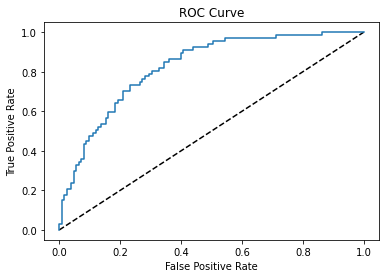

In [9]:
# predicted probability
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="LogReg")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [10]:
# AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


AUC: 0.8231641791044776


### a.	BRIEFLY explain what the ROC Curve shows and what the resulting AUC means. 

The ROC (receiver operating characteristic) curve shows how well a binary classifier system works at various discrimination thresholds by plotting the true positive rate against the false positive rate (recall). The resulting AUC (area under the curve) score puts the ROC curve in a single number which tells how likely it is that, for any given plotted pair of rate values, the system will be able to tell which value is which (ranking a true positive higher than a false positive).

## 4.	What is outlier detection? Why is it useful? What methods can you use for outlier detection?

Outliers are observations or data points which behave significantly differently compared to the rest of the dataset; they can be non-natural (the result of incorrect data collection or entry), or natural (high or low prices, fraud cases in unexpected places, etc.). Detecting outliers is important because they may reveal errors which need to be fixed, or they may skew data measures like mean and standard deviation, as well as the process of prediction.

Outliers can be detected by analyzing the data -- looking for high or low values, values that are not possible in the context of the scenario, or values that are incorrectly formatted. Univariate and multivariate analysis and plotting can reveal outliers (box and scatterplots, calculating mean, standard deviation, or IQR].

More advanced techniques include the elliptic envelope, the isolation forest, and the local outlier factor algorithm. 

In scikit-learn, we can get more tailored data shapes than with box plots and IQRs by using the elliptic envelope technique, in which the object covariance.EllipticEnvelope fits an ellipsis to the central core of the data. In contrast, the isolation forest partitions data points recursively by randomly selecting a feature and then a split value randomly placed between the maximun and minimum values of that feature.

Finally, the local outlier factor (LOF) algorithm calculates a local outlier factor score for the abnormality of the data points. The score represents how densely packed the data point is with respect to its neighbors (also called "local density"); a lower score means the data point is in an area that is less dense with other neighboring data points. The LOF algorithm is useful in many types of datasets because it takes both local conditions and overall conditions into account for each outlier.

## 5.	Perform a linear SVM to predict credit approval (last column) using this dataset: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29 . Make sure you look at the accompanying document that describes the data in the dat file. You will need to either convert this data to another file type or import the dat file to python. 
You can use this code, but otherwise you follow standard practices we have already used many times: 
from sklearn.svm import SVC
classifier = SVC(kernel='linear')

In [3]:
# import dataset
credit_df = pd.read_csv("credit.csv")
credit_df.head()

#per the Data Set Description,
# Missing values WERE REPLACED BY THE MODE OF THE ATTRIBUTE (CATEGORICAL) or MEAN OF THE ATTRIBUTE (CONTINUOUS)

# predict A15 (approved or not)
X = credit_df.drop('A15', axis=1)
y = credit_df['A15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# C is the SVM regularization parameter
C = 1.0

# Create an Instance of SVM and Fit out the data (unscaled)
model = svm.SVC(kernel ='linear', C = 1.0).fit(X_train, y_train)

y_pred = model.predict(X_test)

### a.	How did the SVM model perform? 

In [4]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8695652173913043
Precision: 0.8552631578947368
Recall: 0.8024691358024691


### pretty new beta website

https://archive-beta.ics.uci.edu/ml/datasets/statlog+australian+credit+approval

## 6.	What kinds of jobs in data are you most interested in? Do some research on what is out there. Write about your thoughts in under 400 words. 

I did some research on job opportunities before I applied to the Launchcode CoderGirl program, and what I see now is much the same: there are A LOT of job openings for data scientists in lots of different settings and fields. I am most attracted to data science jobs which contribute to a greater good in some way or which directly affect how people enjoy their lives. In particular, I would love to work for Apple or Spotify - I've seen job openings at both - where I would be analyzing what people are listening to and how they're listening to it, and helping serve up new music to them.

There are also a fair amount of "data storage/retrival" openings, some of which directly require a library/information science degree (yay!), where I would be building/maintaining infrastructure or developing queries that would help people get the information they need.

Another type of setting I'm interested in is academia; for example, there are a couple of intriguing openings at the University of Washington's public health studies department and Georgia University's NISS (a department which gathers data about student success and develops initiatives to bolster it).

Overall, I'm a bit of a generalist, which is to say I'm interested in a lot of different subjects, but I can say with some certainty that I would not like to work in the banking or insurance industries. Otherwise, I'm open to the possibilities!


Data Librarian
https://www.linkedin.com/jobs/view/2874913641/?alternateChannel=search&refId=YIQwL2xdTPUXNn8yajtP4w%3D%3D&trackingId=w1y%2F%2FNGyTC67LokV%2Fe5izg%3D%3D

Data Scientist
https://www.linkedin.com/jobs/view/2873152779/?alternateChannel=search&refId=SuloQGTTVCpOYXN9psCKsg%3D%3D&trackingId=vsy%2Fx4qH02eKP6xop0JoMw%3D%3D

Data Scientist for a fragrances company
https://www.linkedin.com/jobs/view/2879142953/?alternateChannel=search&refId=xhExKeOjISKl0ZzZOUwU%2FQ%3D%3D&trackingId=8oJD0y5JHDMi%2FiG7bIJPsA%3D%3D

spacecraft Subsystem data scientist
https://www.linkedin.com/jobs/view/2869122390/?alternateChannel=search&refId=xhExKeOjISKl0ZzZOUwU%2FQ%3D%3D&trackingId=1gbqFVMiDxrp7pExFCZ4dQ%3D%3D

Apple Music Content Data Scientist
https://www.linkedin.com/jobs/view/2876694475/?alternateChannel=search&refId=Jz4PWWjLXAP2eiBmjqT7%2FQ%3D%3D&trackingId=nUAHiaMhSmkLPfn5KMBXXw%3D%3D

Data Librarian/Curator
https://www.linkedin.com/jobs/view/2866540571/?alternateChannel=search&refId=td0AQGZykLQvYL6OMNeYkA%3D%3D&trackingId=7gQP0JdUaHmRaeBI24cPOA%3D%3D

### Resources

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/

https://scikit-learn.org/stable/modules/outlier_detection.html

## Certificates

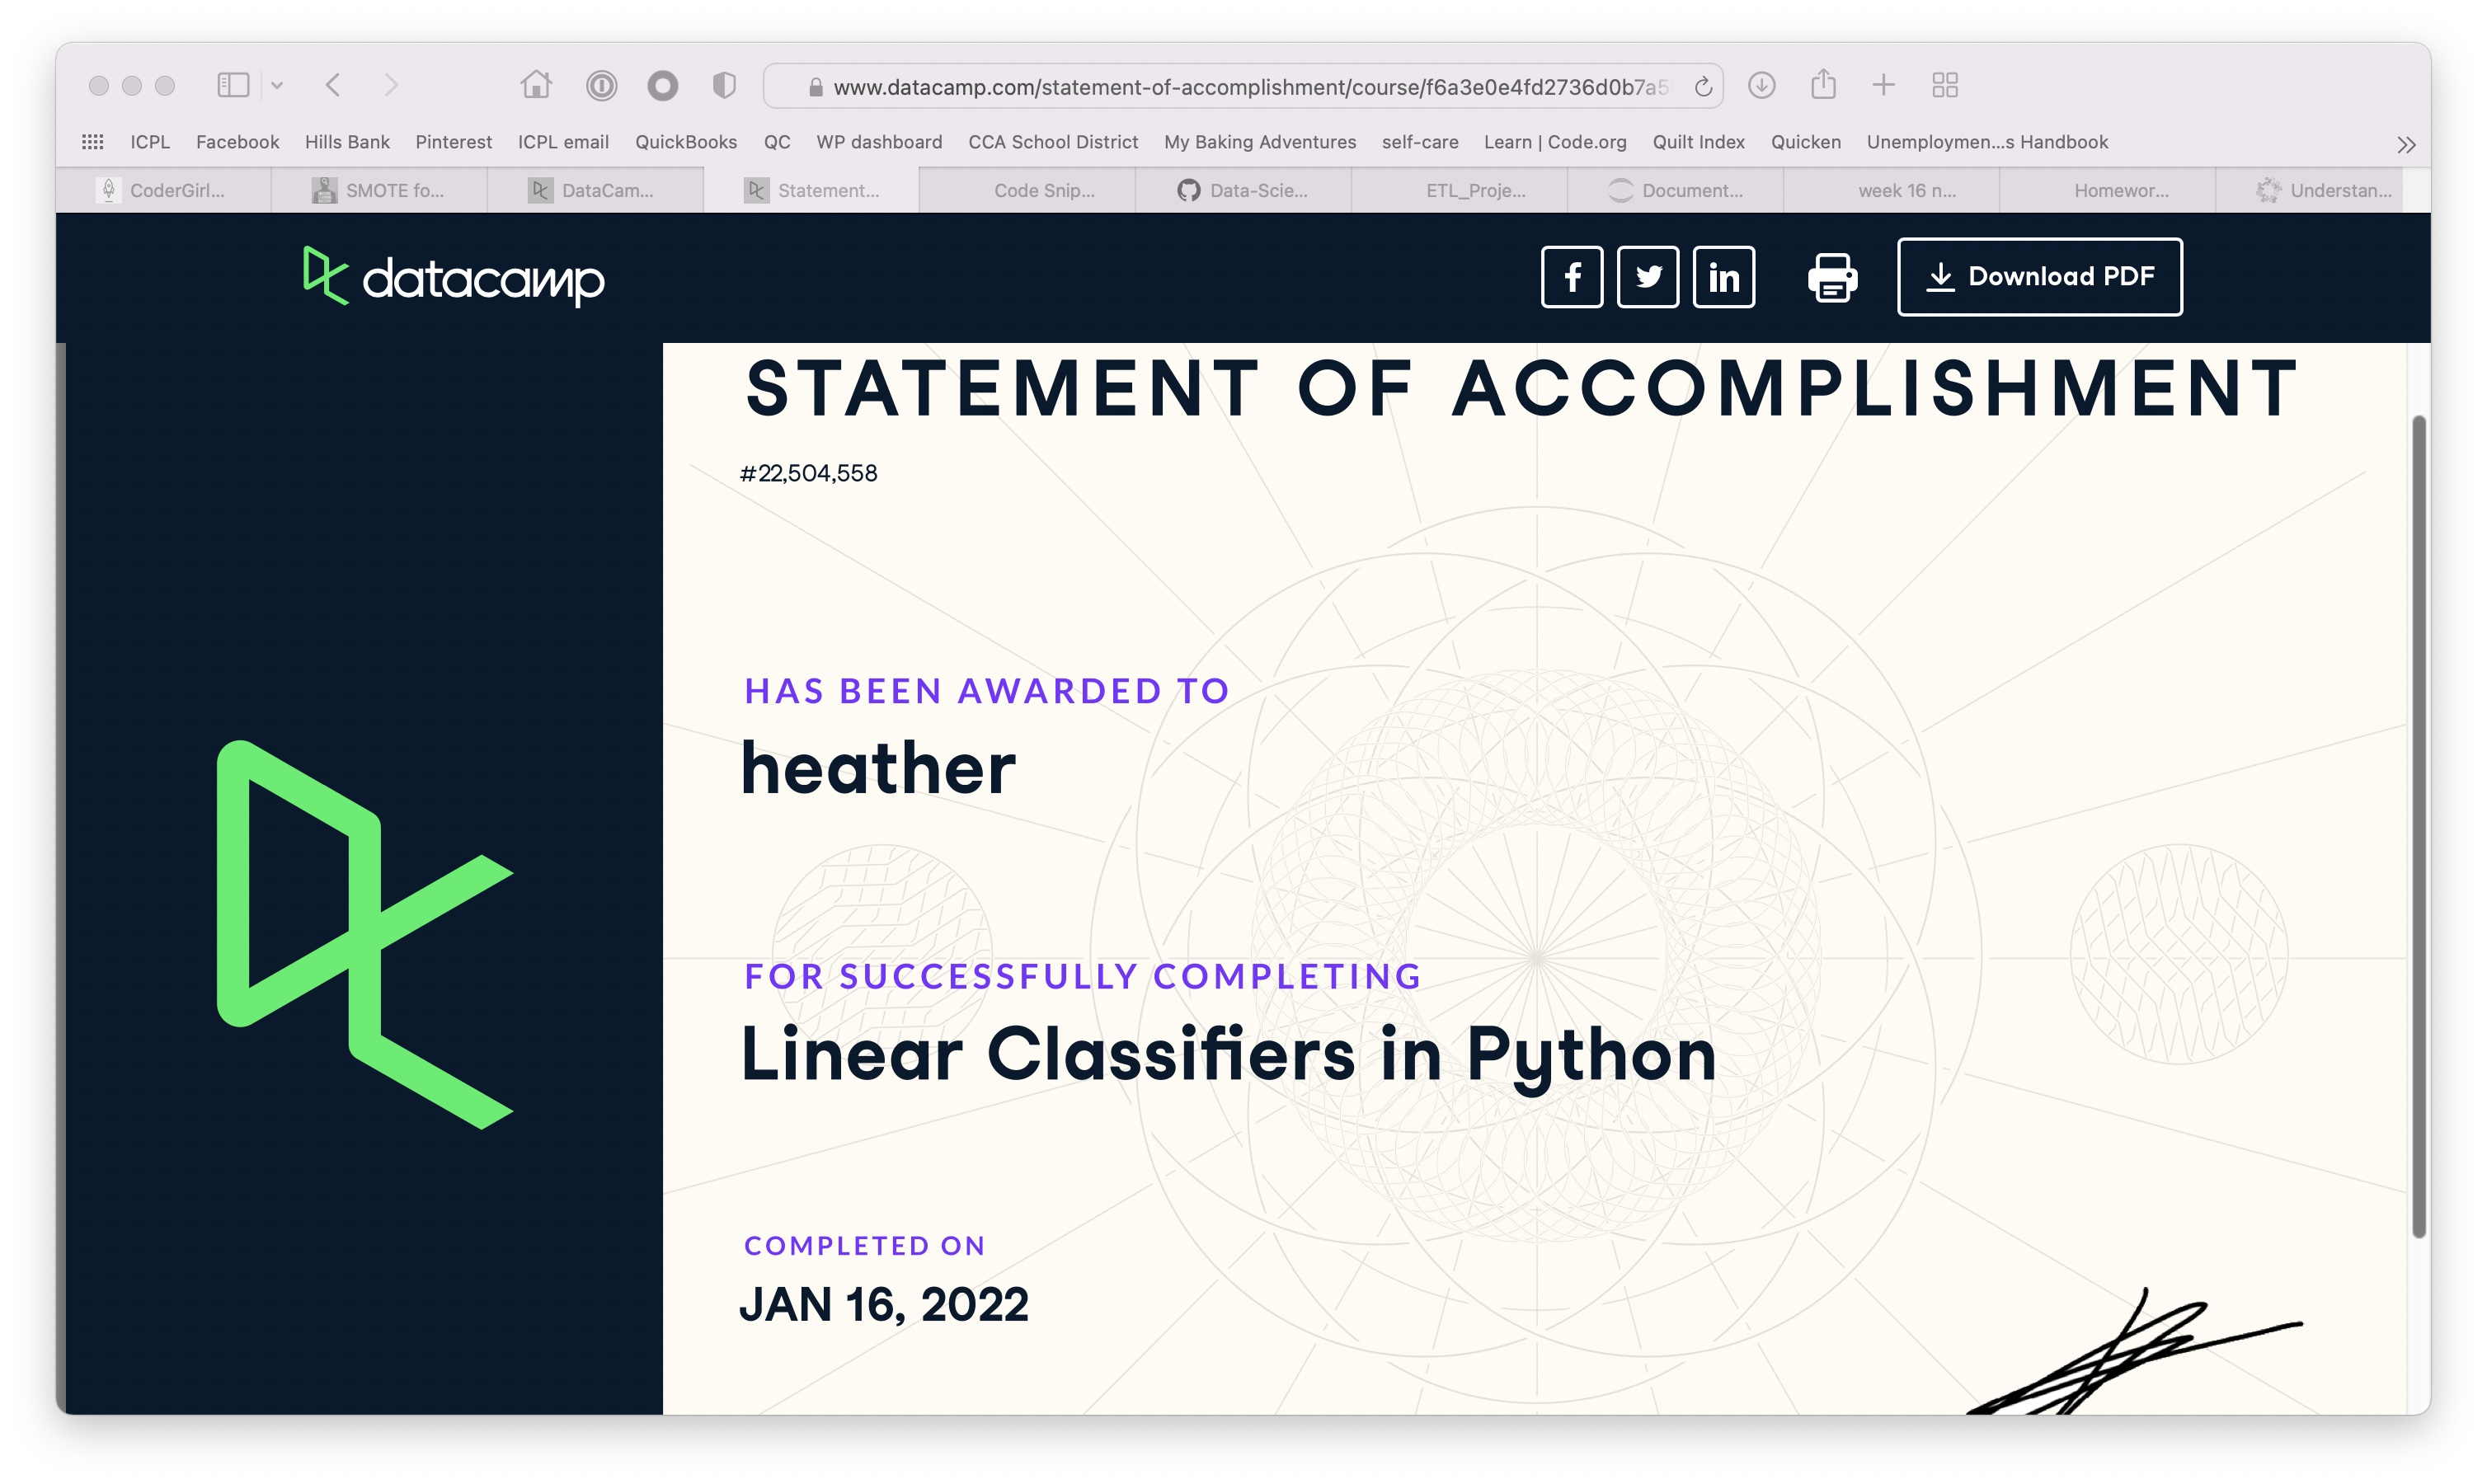

Python ToolBox Pt 2 (first two chapters completed 1/18, final chapter completed 1/23

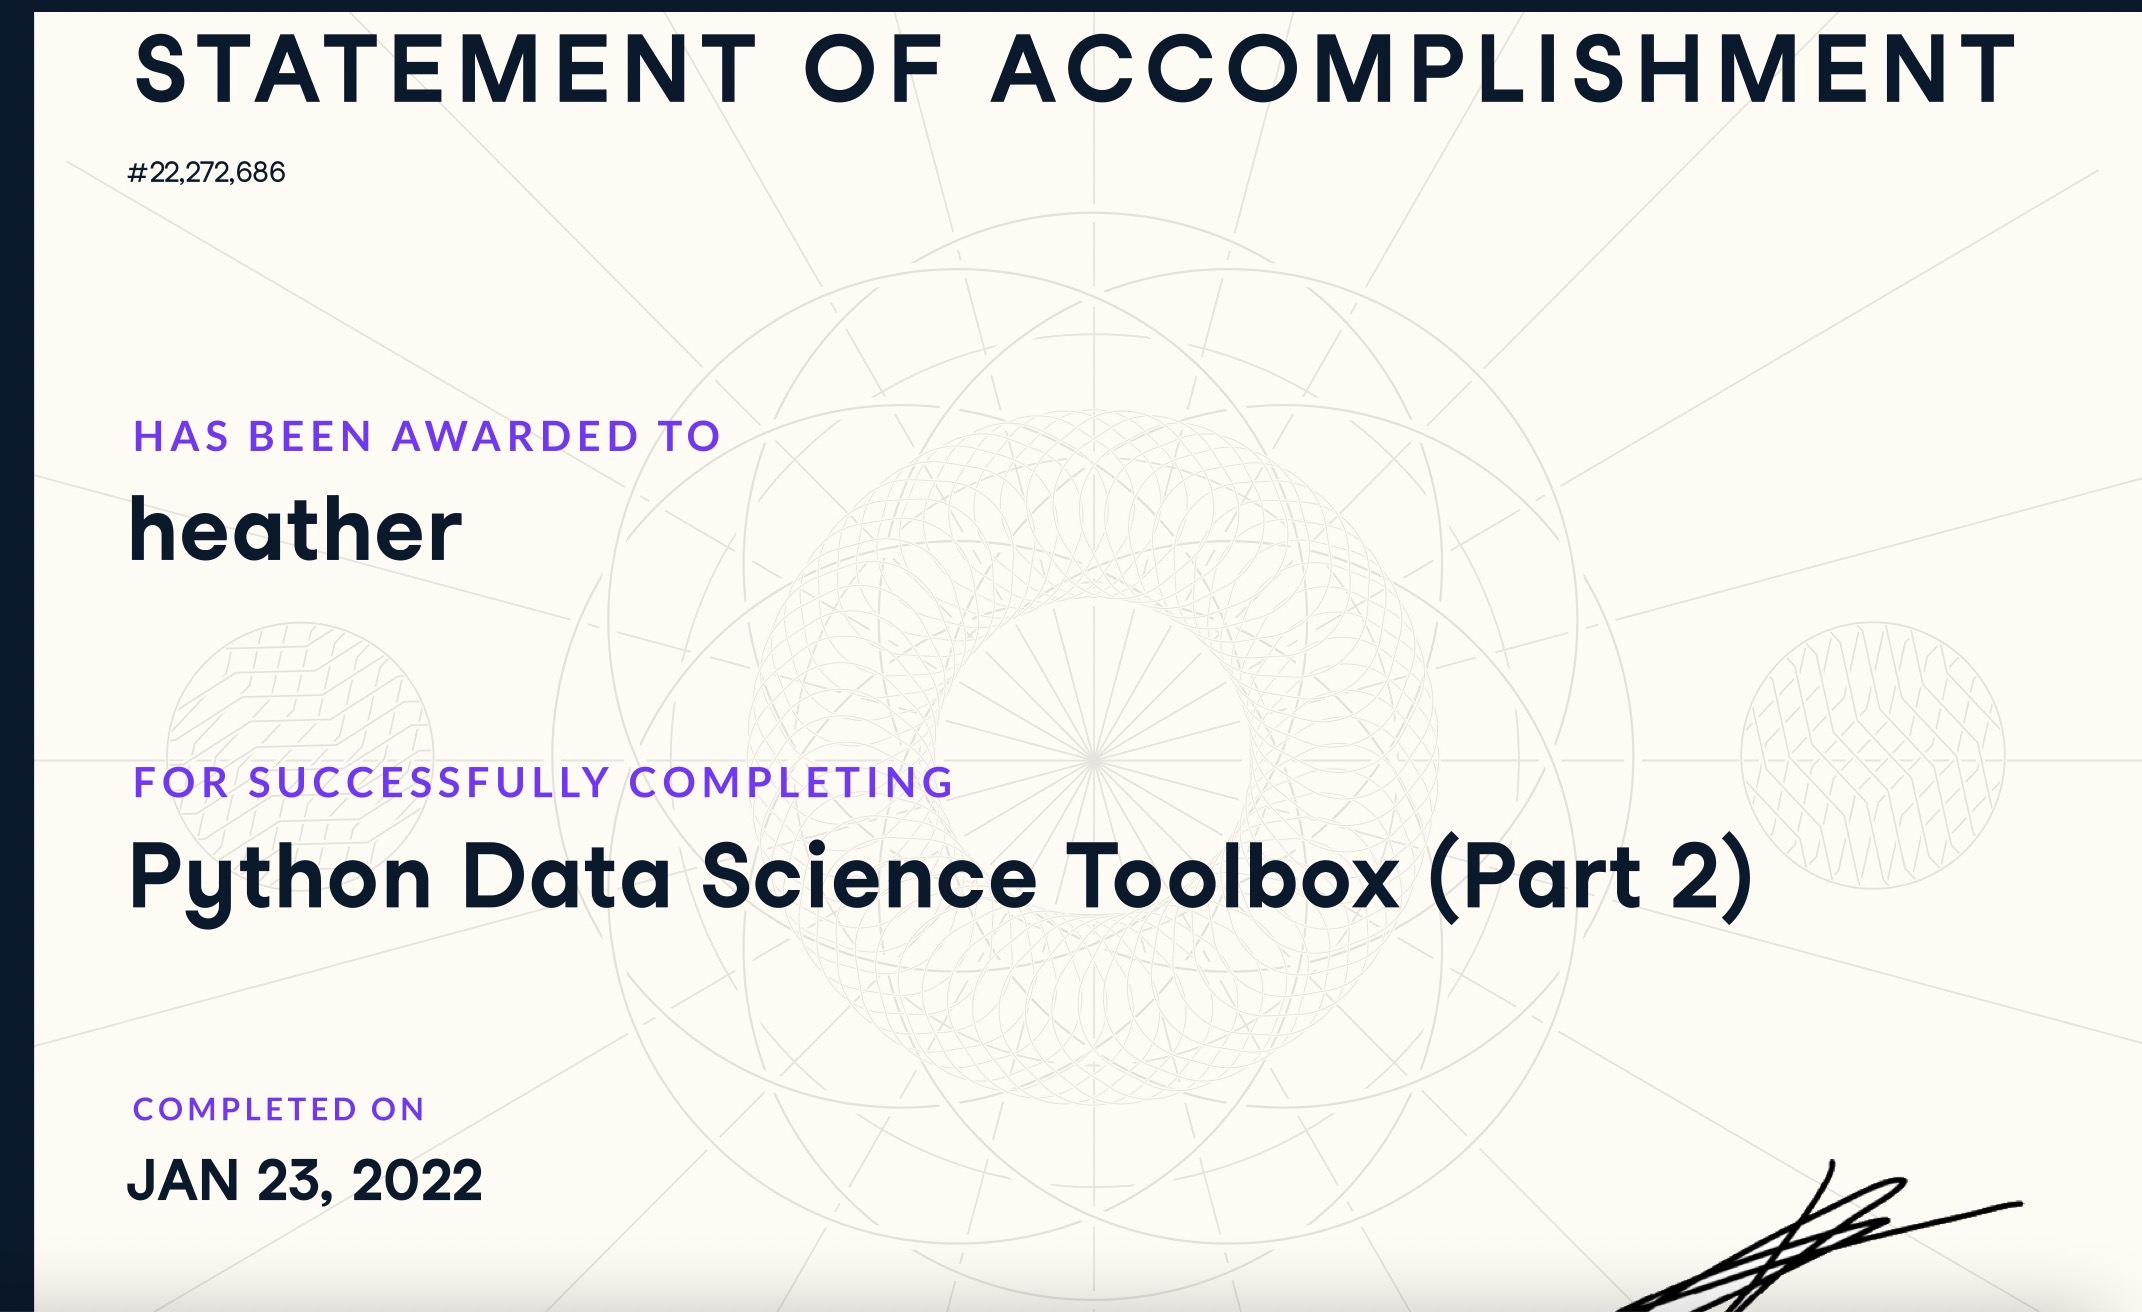